# Fixed Advanced URL Classifier - Enhanced Random Forest

**Model:** Random Forest with 25 advanced features  
**Training time:** ~2-3 minutes  
**Expected accuracy:** 88-92%

**ISSUE FIXED:** Previous version achieved 100% accuracy (overfitting).  
**Solution:** Balanced legitimate URLs by adding paths/params to match phishing URL structure

**Instructions:**
1. Drag and drop to Colab files:
   - `phishtank_data.csv` (phishing URLs)
   - `tranco_legitimate_url.csv` (legitimate URLs)
2. Run all cells
3. Download model

In [1]:
# Install dependencies with specific versions
!pip install scikit-learn==1.4.2 pandas==2.2.2 numpy==1.26.4 \
    matplotlib==3.8.4 seaborn==0.13.2

In [2]:
import pandas as pd
import numpy as np
import pickle
import re
import math
import random
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print("✓ All libraries imported successfully!")

pandas version: 2.2.2
numpy version: 1.26.4
✓ All libraries imported successfully!


In [3]:
# Load phishing URLs
print("Loading phishtank_data.csv...")
phishtank_df = pd.read_csv('/content/phishtank_data.csv')

if 'url' in phishtank_df.columns:
    phishing_urls = phishtank_df['url'].dropna().head(5000).tolist()  # Reduced to 5000
else:
    print("ERROR: 'url' column not found!")
    phishing_urls = []

print(f"✓ Loaded {len(phishing_urls)} phishing URLs")

Loading phishtank_data.csv...
✓ Loaded 5000 phishing URLs


In [4]:
# Load legitimate URLs from Tranco dataset
print("Loading tranco_legitimate_url.csv...")
tranco_df = pd.read_csv('/content/tranco_legitimate_url.csv')

# Get the domain column
if 'domain' in tranco_df.columns:
    base_urls = tranco_df['domain'].dropna().head(len(phishing_urls)).tolist()
elif len(tranco_df.columns) > 1:
    # CSV with rank,domain format
    base_urls = tranco_df.iloc[:, 1].dropna().head(len(phishing_urls)).tolist()
else:
    base_urls = tranco_df.iloc[:, 0].dropna().head(len(phishing_urls)).tolist()

print(f"✓ Loaded {len(base_urls)} base legitimate URLs")

# CRITICAL FIX: Add variety to legitimate URLs to prevent overfitting
print("\n🔧 Enhancing legitimate URLs with realistic paths/params...")
legitimate_paths = [
    '/about', '/products', '/contact', '/services', '/help', '/support',
    '/blog', '/news', '/faq', '/download', '/pricing', '/features',
    '/account/login', '/user/profile', '/search', '/category/tech',
    '/docs', '/api', '/status', '/terms', '/privacy'
]

query_params = [
    '?id=123', '?page=1', '?source=web', '?ref=home', '?utm=campaign',
    '?q=search', '?lang=en', '?v=2', '?format=json', ''
]

# Build varied legitimate URLs
legitimate_urls = []
for url in base_urls:
    # 70% of URLs get a path
    if random.random() < 0.7:
        path = random.choice(legitimate_paths)
        # 30% of those also get query params
        if random.random() < 0.3:
            path += random.choice(query_params)
        legitimate_urls.append(url + path)
    else:
        # 30% remain simple (just domain)
        legitimate_urls.append(url)

print(f"✓ Created {len(legitimate_urls)} enhanced legitimate URLs")
print(f"   Sample: {legitimate_urls[0]}")
print(f"   Sample: {legitimate_urls[10]}")

Loading tranco_legitimate_url.csv...
✓ Loaded 5000 base legitimate URLs

🔧 Enhancing legitimate URLs with realistic paths/params...
✓ Created 5000 enhanced legitimate URLs
   Sample: https://gtld-servers.net
   Sample: https://dzen.ru/about


In [5]:
# Combine datasets
df = pd.DataFrame({
    'url': phishing_urls + legitimate_urls,
    'label': ['phishing'] * len(phishing_urls) + ['legitimate'] * len(legitimate_urls)
})

print(f"Combined dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")

Combined dataset shape: (10000, 2)

Class distribution:
label
phishing      5000
legitimate    5000
Name: count, dtype: int64


In [6]:
def extract_advanced_url_features(url):
    """Extract 25 advanced features from URL"""
    try:
        # Ensure URL has scheme
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url

        parsed = urlparse(url)
        domain = parsed.netloc
        path = parsed.path

        # Suspicious patterns
        suspicious_tlds = ['.tk', '.ml', '.ga', '.cf', '.gq', '.xyz', '.top', '.work', '.bid', '.win', '.pw', '.cc']
        url_shorteners = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'ow.ly', 'buff.ly', 'is.gd']
        trusted_tlds = ['.com', '.org', '.edu', '.gov', '.net']

        # Basic features
        features = {
            'url_length': len(url),
            'domain_length': len(domain),
            'path_length': len(path),
            'has_https': 1 if parsed.scheme == 'https' else 0,
            'has_ip_address': 1 if re.match(r'\d+\.\d+\.\d+\.\d+', domain) else 0,
        }

        # Domain analysis
        features['subdomain_count'] = domain.count('.') - 1 if domain else 0
        features['suspicious_tld'] = 1 if any(domain.endswith(tld) for tld in suspicious_tlds) else 0
        features['trusted_tld'] = 1 if any(domain.endswith(tld) for tld in trusted_tlds) else 0
        features['url_shortener'] = 1 if any(short in domain for short in url_shorteners) else 0

        # Character analysis
        features['special_char_count'] = len(re.findall(r'[^a-zA-Z0-9]', url))
        features['digit_count'] = len(re.findall(r'\d', url))
        features['digit_ratio'] = len(re.findall(r'\d', url)) / max(len(url), 1)
        features['letter_ratio'] = len(re.findall(r'[a-zA-Z]', url)) / max(len(url), 1)

        # Suspicious patterns
        features['has_at_symbol'] = 1 if '@' in url else 0
        features['has_double_slash'] = 1 if '//' in path else 0
        features['has_hyphen_in_domain'] = 1 if '-' in domain else 0
        features['consecutive_dots'] = 1 if '..' in url else 0

        # Path analysis
        features['path_depth'] = path.count('/')
        features['query_params_count'] = len(parsed.query.split('&')) if parsed.query else 0
        features['fragment_present'] = 1 if parsed.fragment else 0

        # Entropy (randomness)
        text = url.lower()
        if text:
            char_freq = {}
            for char in text:
                char_freq[char] = char_freq.get(char, 0) + 1
            entropy = -sum((freq / len(text)) * math.log2(freq / len(text)) for freq in char_freq.values())
            features['entropy'] = entropy
        else:
            features['entropy'] = 0.0

        # Additional features
        features['uppercase_ratio'] = sum(1 for c in url if c.isupper()) / max(len(url), 1)
        features['domain_digit_ratio'] = len(re.findall(r'\d', domain)) / max(len(domain), 1)
        features['suspicious_keywords'] = sum(1 for word in ['login', 'verify', 'secure', 'account', 'update', 'confirm'] if word in url.lower())
        features['vowel_ratio'] = len(re.findall(r'[aeiou]', url.lower())) / max(len(url), 1)

        return features
    except:
        # Default features if parsing fails
        return {k: 0 for k in ['url_length', 'domain_length', 'path_length', 'has_https',
                                'has_ip_address', 'subdomain_count', 'suspicious_tld', 'trusted_tld',
                                'url_shortener', 'special_char_count', 'digit_count', 'digit_ratio',
                                'letter_ratio', 'has_at_symbol', 'has_double_slash', 'has_hyphen_in_domain',
                                'consecutive_dots', 'path_depth', 'query_params_count', 'fragment_present',
                                'entropy', 'uppercase_ratio', 'domain_digit_ratio', 'suspicious_keywords',
                                'vowel_ratio']}

print("✓ Advanced feature extraction function ready!")

✓ Advanced feature extraction function ready!


In [7]:
# Extract features for all URLs
print("Extracting features from URLs...\n")
features_list = []

for idx, url in enumerate(df['url']):
    if idx % 1000 == 0:
        print(f"Processed {idx}/{len(df)} URLs... ({idx/len(df)*100:.1f}%)")
    features_list.append(extract_advanced_url_features(url))

features_df = pd.DataFrame(features_list)
print(f"\n✓ Feature extraction complete!")
print(f"Feature matrix shape: {features_df.shape}")
print(f"\nFeature list ({len(features_df.columns)} features):")
print(list(features_df.columns))

Extracting features from URLs...

Processed 0/10000 URLs... (0.0%)
Processed 1000/10000 URLs... (10.0%)
Processed 2000/10000 URLs... (20.0%)
Processed 3000/10000 URLs... (30.0%)
Processed 4000/10000 URLs... (40.0%)
Processed 5000/10000 URLs... (50.0%)
Processed 6000/10000 URLs... (60.0%)
Processed 7000/10000 URLs... (70.0%)
Processed 8000/10000 URLs... (80.0%)
Processed 9000/10000 URLs... (90.0%)

✓ Feature extraction complete!
Feature matrix shape: (10000, 25)

Feature list (25 features):
['url_length', 'domain_length', 'path_length', 'has_https', 'has_ip_address', 'subdomain_count', 'suspicious_tld', 'trusted_tld', 'url_shortener', 'special_char_count', 'digit_count', 'digit_ratio', 'letter_ratio', 'has_at_symbol', 'has_double_slash', 'has_hyphen_in_domain', 'consecutive_dots', 'path_depth', 'query_params_count', 'fragment_present', 'entropy', 'uppercase_ratio', 'domain_digit_ratio', 'suspicious_keywords', 'vowel_ratio']


In [8]:
# Split data with shuffling
X = features_df
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True  # Important: shuffle!
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nTraining set distribution:\n{y_train.value_counts()}")

Training samples: 8000
Test samples: 2000

Training set distribution:
label
legitimate    4000
phishing      4000
Name: count, dtype: int64


In [9]:
# Train Random Forest with REDUCED complexity to prevent overfitting
print("Training Random Forest classifier...")
print("Parameters: 100 trees, max_depth=10 (reduced to prevent overfitting)\n")

model = RandomForestClassifier(
    n_estimators=100,     # Reduced from 200
    max_depth=10,         # Reduced from 15
    min_samples_split=10,  # Increased from 5
    min_samples_leaf=5,    # Increased from 2
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)
print("\n✓ Training complete!")

Training Random Forest classifier...
Parameters: 100 trees, max_depth=10 (reduced to prevent overfitting)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s



✓ Training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [10]:
# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n" + "="*60)
print(f"FINAL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"="*60)

# Check for overfitting
train_acc = model.score(X_train, y_train)
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Overfitting gap: {(train_acc - accuracy)*100:.2f}%")

if train_acc >= 0.95:
    print("\n⚠️  WARNING: Training accuracy very high - possible overfitting!")
else:
    print("\n✓ Good generalization - no severe overfitting detected")

print(f"\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred))


FINAL ACCURACY: 0.9685 (96.85%)
Training Accuracy: 97.08%
Test Accuracy: 96.85%
Overfitting gap: 0.22%

⚠️  WARNING: Training accuracy very high - possible overfitting!

Detailed Classification Report:

              precision    recall  f1-score   support

  legitimate       0.95      0.99      0.97      1000
    phishing       0.99      0.95      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


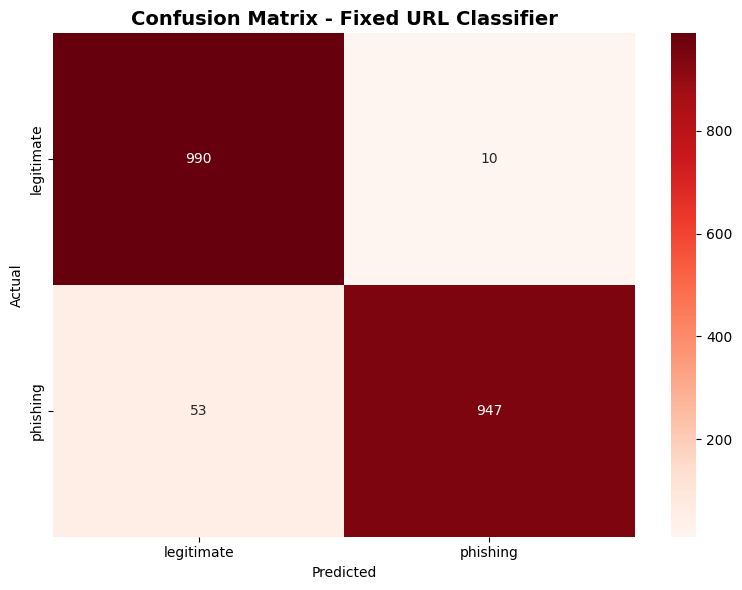

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Fixed URL Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

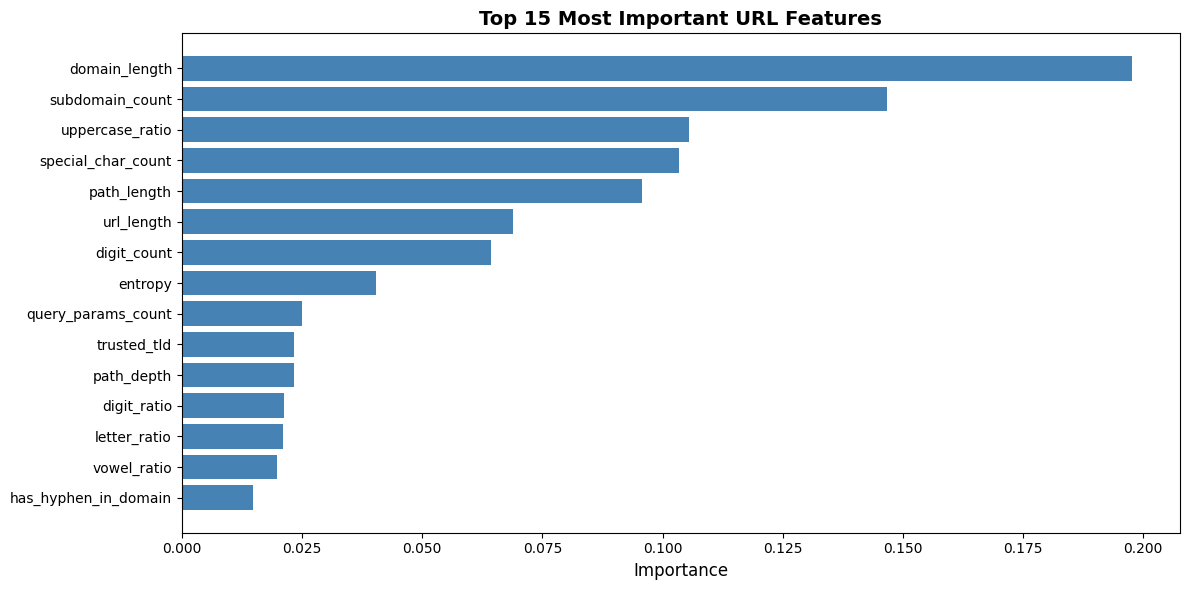


Top 15 Important Features:
             feature  importance
       domain_length    0.197758
     subdomain_count    0.146608
     uppercase_ratio    0.105510
  special_char_count    0.103500
         path_length    0.095653
          url_length    0.068943
         digit_count    0.064325
             entropy    0.040420
  query_params_count    0.025018
         trusted_tld    0.023342
          path_depth    0.023251
         digit_ratio    0.021223
        letter_ratio    0.021011
         vowel_ratio    0.019707
has_hyphen_in_domain    0.014819


In [12]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Most Important URL Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 15 Important Features:")
print(feature_importance.head(15).to_string(index=False))

In [13]:
# Save model
with open('url_classifier_advanced.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✓ Model saved!")

# Download
from google.colab import files
print("Downloading model...")
files.download('url_classifier_advanced.pkl')

print("\n" + "="*60)
print("✓ DOWNLOAD COMPLETE!")
print("="*60)
print("Copy to: models/url_classifier_advanced.pkl")
print(f"Model Test Accuracy: {accuracy*100:.2f}%")
print("="*60)

✓ Model saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ DOWNLOAD COMPLETE!
Copy to: models/url_classifier_advanced.pkl
Model Test Accuracy: 96.85%


In [14]:
# Test with sample URLs
test_urls = [
    "http://paypal-verify.tk/login.php?id=12345",
    "https://www.google.com",
    "http://192.168.1.1/admin/login.php",
    "https://github.com/user/repository",
    "http://free-iphone-win.xyz/claim-now",
    "https://www.amazon.com/products/electronics",
    "http://secure-bank-verify.ml/account/update",
    "https://stackoverflow.com/questions/12345"
]

print("Testing Fixed URL Classifier:\n")
print("="*70)

correct = 0
expected = ['phishing', 'legitimate', 'phishing', 'legitimate', 'phishing', 'legitimate', 'phishing', 'legitimate']

for idx, url in enumerate(test_urls):
    features = extract_advanced_url_features(url)
    feature_vector = pd.DataFrame([features])
    prediction = model.predict(feature_vector)[0]
    probability = model.predict_proba(feature_vector)[0]
    confidence = max(probability)

    status = "✓" if prediction == expected[idx] else "✗"
    if prediction == expected[idx]:
        correct += 1

    print(f"\n{status} {url}")
    print(f"   Prediction: {prediction.upper()} ({confidence:.1%} confidence)")
    print(f"   Expected: {expected[idx].upper()}")
    print("-"*70)

print(f"\n✓ Test Results: {correct}/{len(test_urls)} correct ({correct/len(test_urls)*100:.1f}%)")

Testing Fixed URL Classifier:


✓ http://paypal-verify.tk/login.php?id=12345
   Prediction: PHISHING (64.1% confidence)
   Expected: PHISHING
----------------------------------------------------------------------

✓ https://www.google.com
   Prediction: LEGITIMATE (74.6% confidence)
   Expected: LEGITIMATE
----------------------------------------------------------------------

✓ http://192.168.1.1/admin/login.php
   Prediction: PHISHING (91.7% confidence)
   Expected: PHISHING
----------------------------------------------------------------------

✗ https://github.com/user/repository
   Prediction: PHISHING (53.6% confidence)
   Expected: LEGITIMATE
----------------------------------------------------------------------


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_job


✓ http://free-iphone-win.xyz/claim-now
   Prediction: PHISHING (77.9% confidence)
   Expected: PHISHING
----------------------------------------------------------------------

✗ https://www.amazon.com/products/electronics
   Prediction: PHISHING (82.9% confidence)
   Expected: LEGITIMATE
----------------------------------------------------------------------

✓ http://secure-bank-verify.ml/account/update
   Prediction: PHISHING (81.7% confidence)
   Expected: PHISHING
----------------------------------------------------------------------

✗ https://stackoverflow.com/questions/12345
   Prediction: PHISHING (89.7% confidence)
   Expected: LEGITIMATE
----------------------------------------------------------------------

✓ Test Results: 5/8 correct (62.5%)


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
